<a href="https://colab.research.google.com/github/FrancoCalcia/AA2-TP2-Avecilla-Calcia-Rizzotto.ipynb/blob/main/AA2_TP2_Avecilla_Calcia_Rizzotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problema 1

In [95]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as display


AUTOTUNE = tf.data.AUTOTUNE

##1. Carga del dataset y split

In [96]:
# - train[:80%]  → primeros 80% de los 2.500 ejemplos → 2.000 muestras
# - train[80%:]  → últimos 20%                   →   500 muestras
(ds_train, ds_val), ds_info = tfds.load(
    "spoken_digit",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,   # cada elemento será (audio, etiqueta)
    with_info=True
)

label_names = np.array(ds_info.features["label"].names)
print("Clases disponibles:", label_names)
print("Ejemplos en ds_train:", tf.data.experimental.cardinality(ds_train).numpy())
print("Ejemplos en ds_val:",   tf.data.experimental.cardinality(ds_val).numpy())

Clases disponibles: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Ejemplos en ds_train: 2000
Ejemplos en ds_val: 500


## 2. “Squeeze” + mostrar algunas formas de onda

In [97]:
TARGET_LENGTH = 8000
def squeeze_audio(audio, label):
    """
    Asegura que cada clip tenga exactamente TARGET_LENGTH muestras en 1D.
    - Si el clip es más corto, lo rellena con ceros al final.
    - Si el clip es más largo, lo trunca a TARGET_LENGTH.
    Además normaliza la señal a float32 en [-1,1].
    """
    # 1) Convertir a float32 [-1,1]
    audio = tf.cast(audio, tf.float32) / 32768.0
    # 2) Quitar cualquier dimensión extra
    audio = tf.squeeze(audio)

    length = tf.shape(audio)[0]

    # 3) Si es más corto, pad con ceros; si es más largo, tomar los primeros TARGET_LENGTH
    def _pad():
        return tf.pad(audio, [[0, TARGET_LENGTH - length]])
    def _truncate():
        return audio[:TARGET_LENGTH]

    audio = tf.cond(length < TARGET_LENGTH, _pad, _truncate)
    # Ahora audio tiene shape [TARGET_LENGTH]
    return audio, label

# Aplicamos el squeeze_audio en train_ds y val_ds
train_ds = ds_train.map(squeeze_audio, num_parallel_calls=AUTOTUNE)
val_ds   = ds_val.map(squeeze_audio,   num_parallel_calls=AUTOTUNE)


In [98]:
train_ds_batched = (
    train_ds
    .shuffle(2000, seed=0)
    .batch(9, drop_remainder=True)
    .prefetch(AUTOTUNE)
)

for batch_audio, batch_labels in train_ds_batched.take(1):
    print("Shape batch_audio:", batch_audio.shape)   # -> (9, 8000)
    print("Shape batch_labels:", batch_labels.shape) # -> (9,)
    example_audio  = batch_audio.numpy()
    example_labels = batch_labels.numpy()
    break



Shape batch_audio: (9, 8000)
Shape batch_labels: (9,)


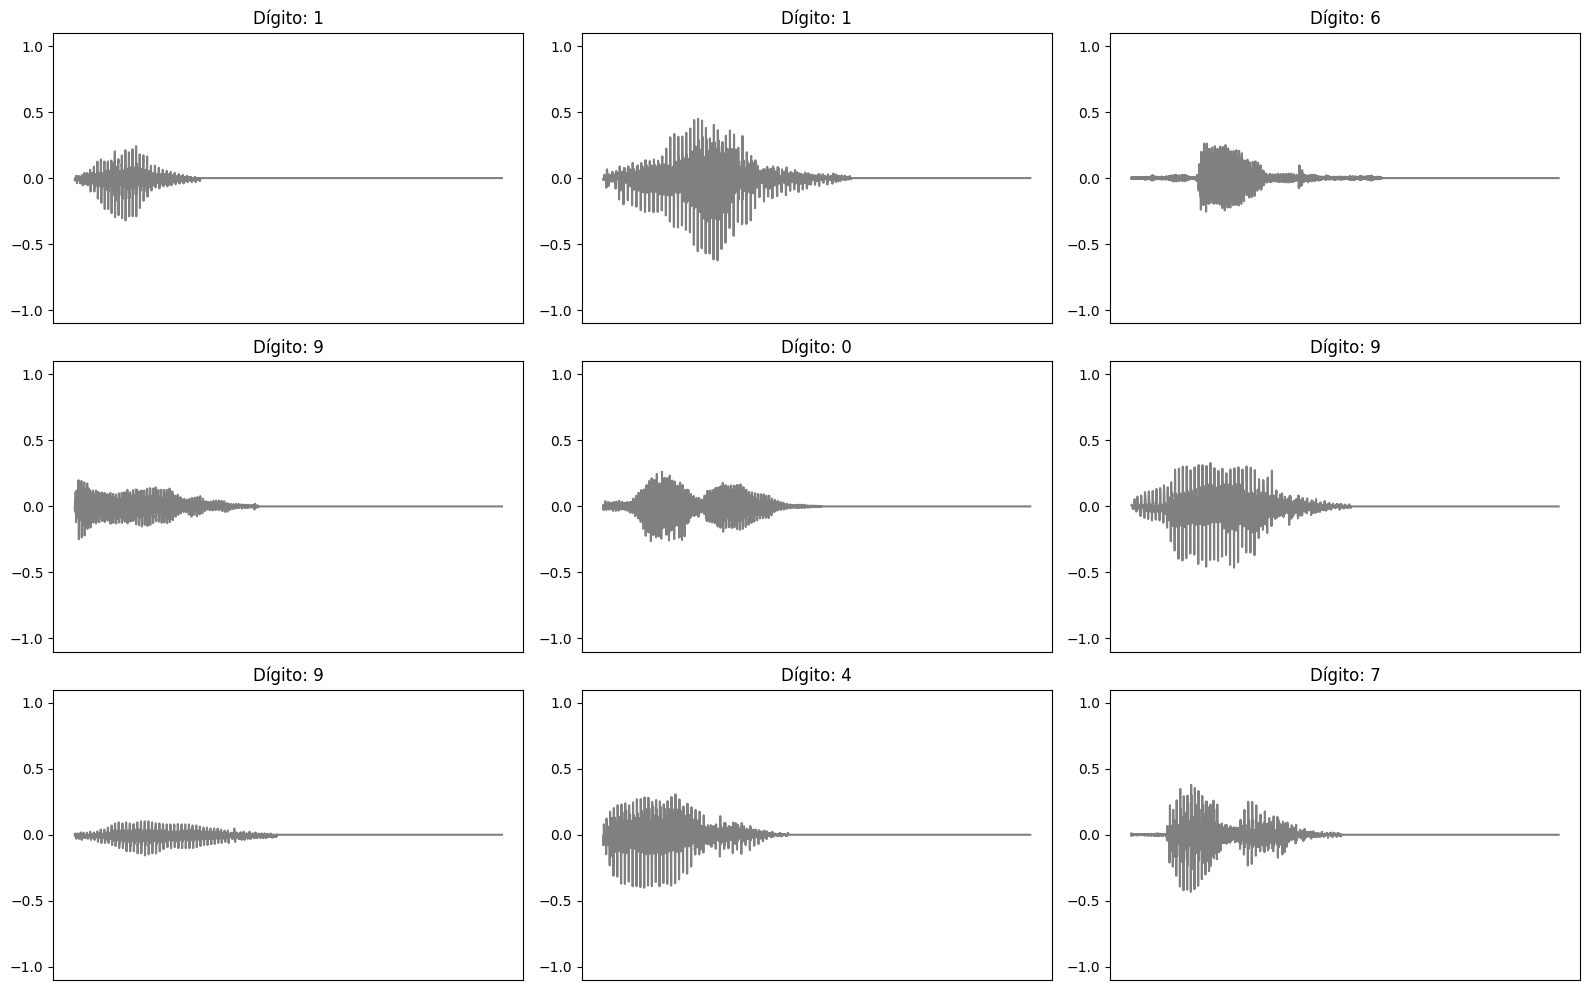

In [99]:
plt.figure(figsize=(16, 10))
rows, cols = 3, 3

for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    etiqueta     = example_labels[i]
    ax.plot(audio_signal, color="gray")
    ax.set_title(f"Dígito: {label_names[etiqueta]}")
    ax.set_ylim([-1.1, 1.1])
    ax.set_yticks(np.arange(-1.0, 1.01, 0.5))
    ax.set_xticks([])
plt.tight_layout()
plt.show()


Definir la función get_spectrogram(...)

In [100]:
def get_spectrogram(waveform):
    """
    Input:
      - waveform: tensor 1D de shape [8000], tipo float32 en [-1,1].
    Output:
      - spectrogram: tensor 3D de shape [time_bins, freq_bins, 1],
                     listo para pasarlo a una Conv2D.
    """
    # Parámetros para STFT (puedes ajustar frame_length/frame_step)
    frame_length = 255
    frame_step   = 128

    # 1) STFT → tensor complejo de shape [time_bins, fft_bins]
    spectrogram = tf.signal.stft(
        waveform,
        frame_length=frame_length,
        frame_step=frame_step,
        fft_length=frame_length
    )
    # 2) Magnitud (abs) → shape [time_bins, fft_bins]
    spectrogram = tf.abs(spectrogram)

    # 3) Añadir canal “1” para que se comporte como “imagen” (height, width, channels)
    spectrogram = spectrogram[..., tf.newaxis]  # ahora es [time_bins, freq_bins, 1]
    spectrogram.set_shape([61, 128, 1])

    return spectrogram


Mostrar forma de onda + espectrograma de algunos ejemplos

In [101]:
for i in range(3):
    # example_audio[i] es un array NumPy de forma (8000,)
    waveform_np = example_audio[i]
    etiqueta    = example_labels[i]               # numpy.int64 → int

    # Convertimos a tf.Tensor para get_spectrogram
    waveform = tf.constant(waveform_np, dtype=tf.float32)

    spectrogram = get_spectrogram(waveform)

    print(f"Etiqueta (dígito): {label_names[etiqueta]}")
    print("  Waveform shape:", waveform.shape)          # (<8000>,)
    print("  Spectrogram shape:", spectrogram.shape)    # (time_bins, freq_bins, 1)

    # Reproducir audio directamente en Colab
    display.display(display.Audio(waveform_np, rate=8000))
    print("────────────────────────────────────────")


Etiqueta (dígito): 1
  Waveform shape: (8000,)
  Spectrogram shape: (61, 128, 1)


────────────────────────────────────────
Etiqueta (dígito): 1
  Waveform shape: (8000,)
  Spectrogram shape: (61, 128, 1)


────────────────────────────────────────
Etiqueta (dígito): 6
  Waveform shape: (8000,)
  Spectrogram shape: (61, 128, 1)


────────────────────────────────────────


funcion para mostrar el espectrograma

In [102]:
def plot_spectrogram(spectrogram, ax):
    """
    Dado un tensor 2D o 3D [time_bins, freq_bins, 1],
    graficamos su versión en escala logarítmica (colormap).
    - ax: un Axes de Matplotlib donde queremos dibujar.
    """
    # 1) Si nos llegó con shape [time_bins, freq_bins, 1], lo “squeezeamos”.
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)

    # 2) Pasar a escala log (evitar log(0) con eps)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)

    # 3) Preparamos ejes:
    #    - X será tiempo, Y frecuencia.
    #    - transponemos con .T para que el eje horizontal sea “time bins”.
    height = log_spec.shape[0]  # freq_bins
    width  = log_spec.shape[1]  # time_bins

    # 4) Dibujamos usando pcolormesh
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_ylabel('Freq bins')
    ax.set_xlabel('Time bins')


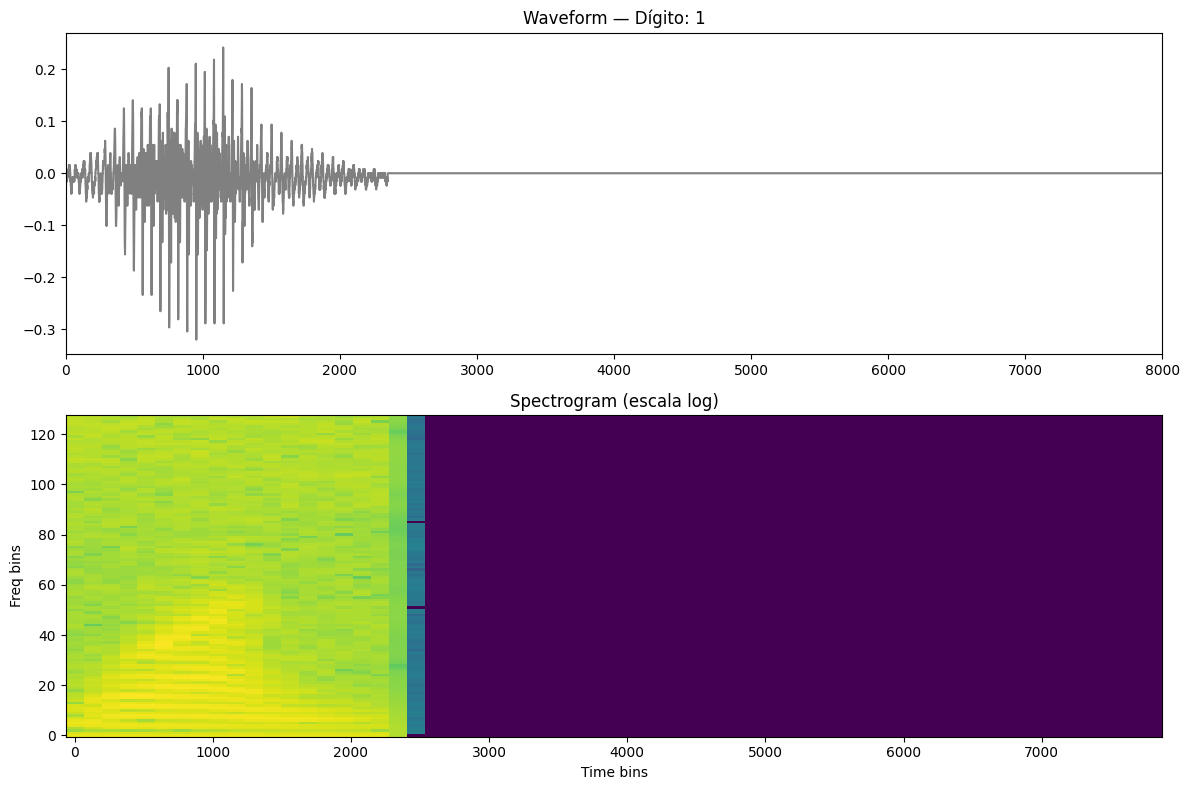

In [103]:
# example_audio[0] es un array NumPy de longitud 8000
wav_np   = example_audio[0]         # NumPy array shape (8000,)
etiqueta  = example_labels[0]       # numpy.int64 (entero 0..9)

# Convertimos la señal a un tensor de TF para get_spectrogram
waveform = tf.constant(wav_np, dtype=tf.float32)

# Obtenemos el espectrograma (tensor TF shape [time_bins, freq_bins, 1])
spectrogram = get_spectrogram(waveform)

# Pasamos ambos a NumPy para plotear
spec_np = spectrogram.numpy()

# Creamos dos subplots: arriba la forma de onda, abajo el espectrograma
fig, axes = plt.subplots(2, figsize=(12, 8))

# Plot Forma de onda
timescale = np.arange(wav_np.shape[0])  # [0,1,2,...,7999]
axes[0].plot(timescale, wav_np, color="gray")
axes[0].set_title(f"Waveform — Dígito: {label_names[int(etiqueta)]}")
axes[0].set_xlim([0, wav_np.shape[0]])

# Plot Spectrograma
plot_spectrogram(spec_np, axes[1])
axes[1].set_title("Spectrogram (escala log)")

plt.tight_layout()
plt.show()



## Crear los datasets “solo espectrogramas”: train_spectrogram_ds y val_spectrogram_ds

Para que la red (ya sea CNN o RNN) reciba directamente espectrogramas, podemos hacer:

In [104]:
#  Función que convierte (audio, label) → (spectrogram, label)
def make_spectrogram_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=AUTOTUNE
    )

#  Generamos los nuevos datasets (sin agrupar aún en batches)
train_spectrogram_ds = make_spectrogram_ds(train_ds)
val_spectrogram_ds   = make_spectrogram_ds(val_ds)

# Tomamos un batch de 9 espectrogramas para revisar cómo se ven
train_spec_batched = (
    train_spectrogram_ds
    .shuffle(2000, seed=0)
    .batch(9, drop_remainder=True)
    .prefetch(AUTOTUNE)
)

for batch_specs, batch_labels in train_spec_batched.take(1):
    # batch_specs tendrá shape (9, time_bins, freq_bins, 1)
    # batch_labels tendrá shape (9,)
    example_spectrograms = batch_specs
    example_spec_labels  = batch_labels
    break


Graficar los 9 espectrogramas en un grid 3×3

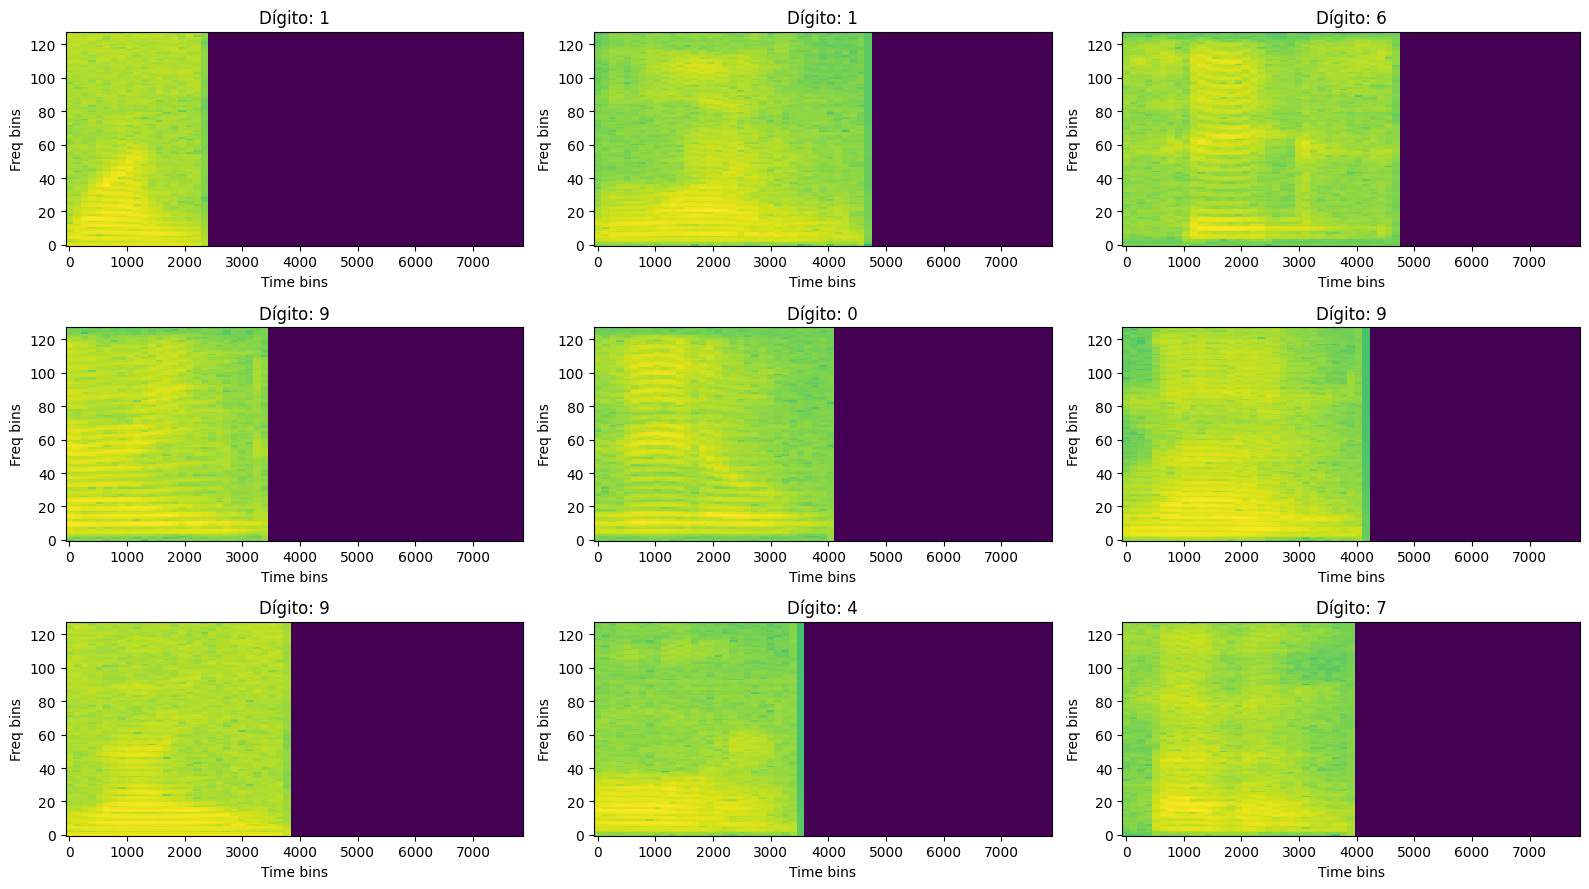

In [105]:
# Preparamos la figura con 3 filas y 3 columnas:
rows = 3
cols = 3
n = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    # Convertimos a NumPy y graficamos con nuestra función
    spec_np = example_spectrograms[i].numpy()
    plot_spectrogram(spec_np, ax)

    etiqueta = example_spec_labels[i].numpy()
    ax.set_title(f"Dígito: {label_names[etiqueta]}")

plt.tight_layout()
plt.show()


## Coonstruir y Entrenar modelo

In [106]:
BATCH_SIZE = 32

train_spectrogram_ds = (
    train_spectrogram_ds
    .cache()
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_spectrogram_ds = (
    val_spectrogram_ds
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


Adaptar la capa de normalización

In [107]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instanciamos la capa Normalization
norm_layer = layers.Normalization()

# Hacemos adapt usando solo los espectrogramas (sin etiquetas)
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (61, 128, 1)


## Definir, compilar y entrenar la CNN

In [108]:
model = models.Sequential([
    layers.Input(shape=input_shape),  # (61,128,1)
    layers.Resizing(32, 32),          # redimensionamos a 32×32
    norm_layer,                       # normalizamos

    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_labels),  # logits (no softmax)
])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_8 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_10                │ (None, 32, 32, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [109]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [110]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=10)
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.3102 - loss: 1.9577 - val_accuracy: 0.6740 - val_loss: 1.1040
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6575 - loss: 1.0533 - val_accuracy: 0.7720 - val_loss: 0.7729
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7397 - loss: 0.7833 - val_accuracy: 0.8540 - val_loss: 0.5184
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8251 - loss: 0.5386 - val_accuracy: 0.8820 - val_loss: 0.4002
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8627 - loss: 0.4340 - val_accuracy: 0.9120 - val_loss: 0.3037
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8644 - loss: 0.3825 - val_accuracy: 0.9360 - val_loss: 0.2658
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9032 - loss: 0.2900 - val_accuracy: 0.9220 - val_loss: 0.2754
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9198 - loss: 0.2531 - val_accuracy: 0.9300 - 

## Graficar curvas y matriz de confusión

Curvas

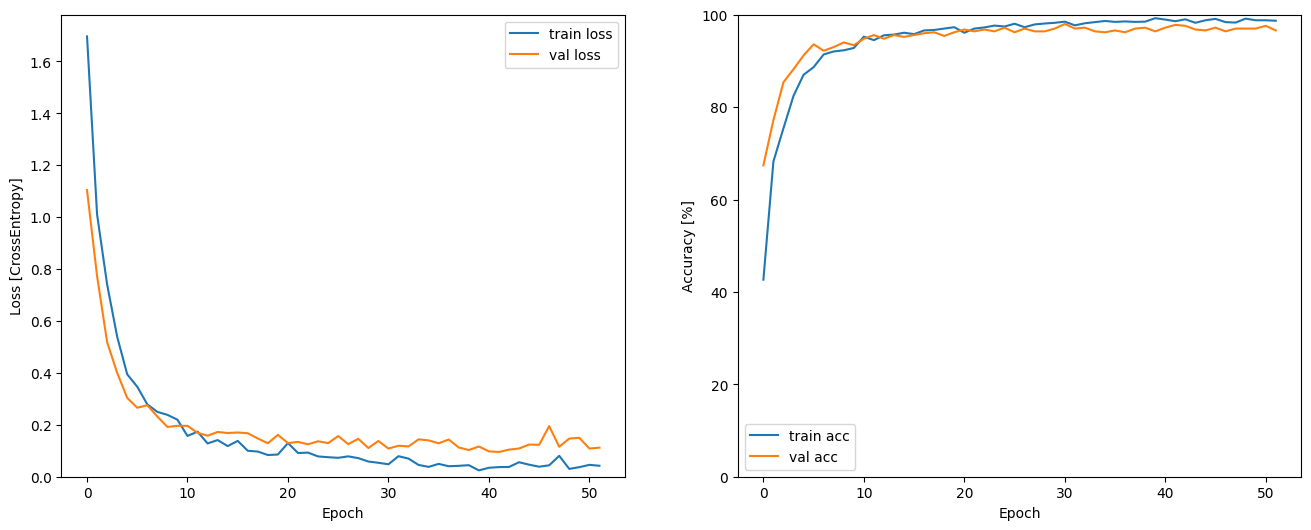

In [111]:
metrics = history.history

plt.figure(figsize=(16,6))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], label='train loss')
plt.plot(history.epoch, metrics['val_loss'], label='val loss')
plt.legend()
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

# Exactitud
plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), label='train acc')
plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), label='val acc')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()


Matriz

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


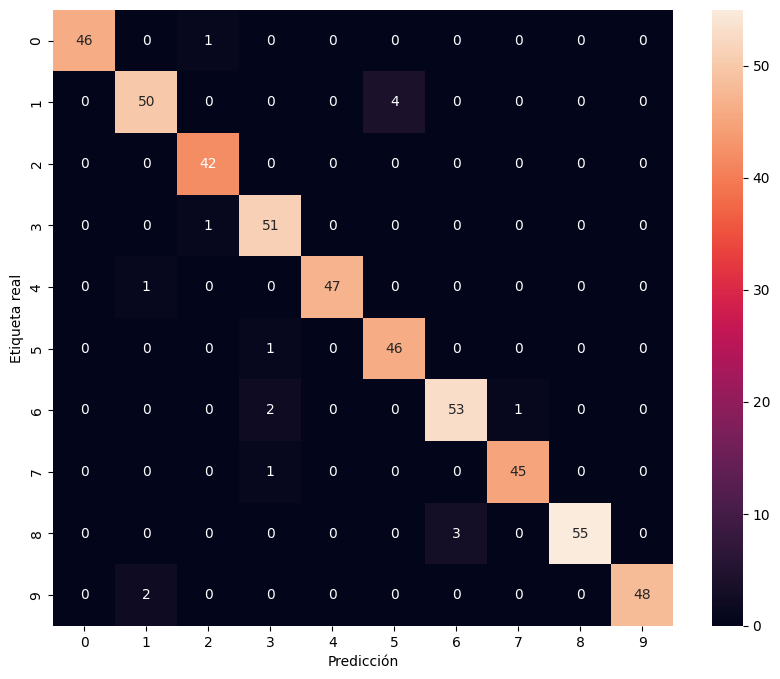

In [112]:
# 5.1) Obtener predicciones
y_pred_logits = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred_logits, axis=1)

# 5.2) Extraer etiquetas verdaderas
y_true = tf.concat(
    list(val_spectrogram_ds.map(lambda spec, lbl: lbl)),
    axis=0
)

# 5.3) Matriz de confusión
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx,
    xticklabels=label_names,
    yticklabels=label_names,
    annot=True, fmt='g'
)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.show()


## Inferimos sobre un audio

In [137]:
# Barajamos los elementos de ds_val y luego tomamos solo uno:
raw_audio, true_label = next(iter(ds_val.shuffle(5000).take(1))) #(ds_val.shuffle(5000, seed=None).take(1)) -> seed si queremos agarrar otro aleatorio

print("Forma cruda del audio (aleatorio):", raw_audio.shape,
      "Etiqueta real:", true_label.numpy())


Forma cruda del audio (aleatorio): (5540,) Etiqueta real: 6


In [138]:
audio_8000, true_label = squeeze_audio(raw_audio, true_label)
print("Después de squeeze_audio:", audio_8000.shape)

Después de squeeze_audio: (8000,)


In [139]:
spec = get_spectrogram(audio_8000)
print("Shape del espectrograma:", spec.shape)  # → (61, 128, 1)

Shape del espectrograma: (61, 128, 1)


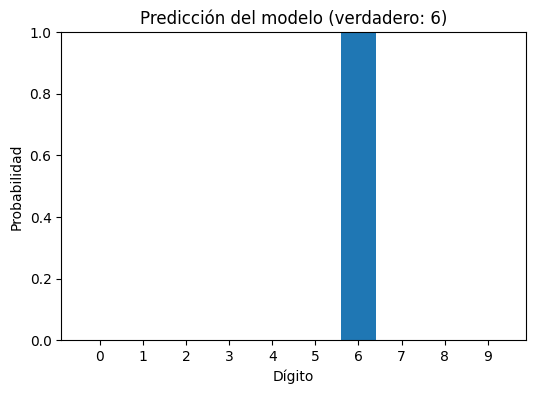

In [140]:
# Añadir dimensión de batch para alimentar al modelo
input_tensor = spec[tf.newaxis, ...]  # (1, 61, 128, 1)

#  Hacer la predicción con el modelo entrenado
logits = model(input_tensor)                       # shape: (1, 10)
probs  = tf.nn.softmax(logits[0])                  # tensor de 10 probabilidades

#  Mostrar los resultados en un gráfico de barras
label_names = np.array(label_names)  # ['0','1',…,'9']
plt.figure(figsize=(6,4))
plt.bar(label_names, probs.numpy())
plt.title(f"Predicción del modelo (verdadero: {label_names[int(true_label)]})")
plt.ylabel("Probabilidad")
plt.xlabel("Dígito")
plt.ylim([0, 1])
plt.show()

#  Reproducir el audio en el notebook
display.display(display.Audio(audio_8000.numpy(), rate=8000))

# RNN

Para que un LSTM lo lea como secuencia de vectores de tamaño 128, basta con “squeezear” el canal. Partiendo de train_spectrogram_ds ya batcheado, creamos train_rnn_ds así:

In [146]:
AUTOTUNE = tf.data.AUTOTUNE

#  Quitamos el canal de cada batch (32, 61, 128, 1) → (32, 61, 128)
train_rnn_ds = train_spectrogram_ds.map(
    lambda spec, lbl: (tf.squeeze(spec, axis=-1), lbl),
    num_parallel_calls=AUTOTUNE
)

#  Hacemos lo mismo para validación
val_rnn_ds = val_spectrogram_ds.map(
    lambda spec, lbl: (tf.squeeze(spec, axis=-1), lbl),
    num_parallel_calls=AUTOTUNE
)


inspeccionamos:

In [147]:
for seqs, labs in train_rnn_ds.take(1):
    print("Espectrogramas para RNN:", seqs.shape)  # → (32, 61, 128)
    print("Etiquetas:", labs.shape)               # → (32,)
    break


Espectrogramas para RNN: (32, 61, 128)
Etiquetas: (32,)


### Definimos arquitetura LSTM

In [148]:
num_labels = len(label_names)  # suele ser 10 (dígitos 0–9)

input_shape_rnn = (61, 128)  # time_bins=61, freq_bins=128

rnn_model = models.Sequential([
    layers.Input(shape=input_shape_rnn),         # (61, 128)

    # 1ª LSTM devuelve la secuencia completa (61 pasos → 61 vectores de 64)
    layers.LSTM(64, return_sequences=True),

    # 2ª LSTM devuelve solo el estado final (vector de 64)
    layers.LSTM(64),

    # Capa intermedia densa
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),

    # Capa final de logits para 10 clases
    layers.Dense(num_labels),
])

rnn_model.summary()

rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 61, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,242 (340.79 KB)

 Trainable params: 87,242 (340.79 KB)

 Non-trainable params: 0 (0.00 B)

## entrenar

In [149]:
EPOCHS = 100

history_rnn = rnn_model.fit(
    train_rnn_ds,
    validation_data=val_rnn_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)]
)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1223 - loss: 2.2678 - val_accuracy: 0.2760 - val_loss: 1.8573
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3037 - loss: 1.7746 - val_accuracy: 0.3380 - val_loss: 1.5265
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3260 - loss: 1.5437 - val_accuracy: 0.3700 - val_loss: 1.2533
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3988 - loss: 1.2806 - val_accuracy: 0.4920 - val_loss: 1.1314
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4779 - loss: 1.1343 - val_accuracy: 0.5540 - val_loss: 1.0453
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5443 - loss: 0.9589 - val_accuracy: 0.5880 - val_loss: 0.9326
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5638 - loss: 0.9941 - val_accuracy: 0.5980 - val_loss: 0.8802
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5583 - loss: 1.0449 - val_accuracy: 0.

## Curvas y matriz

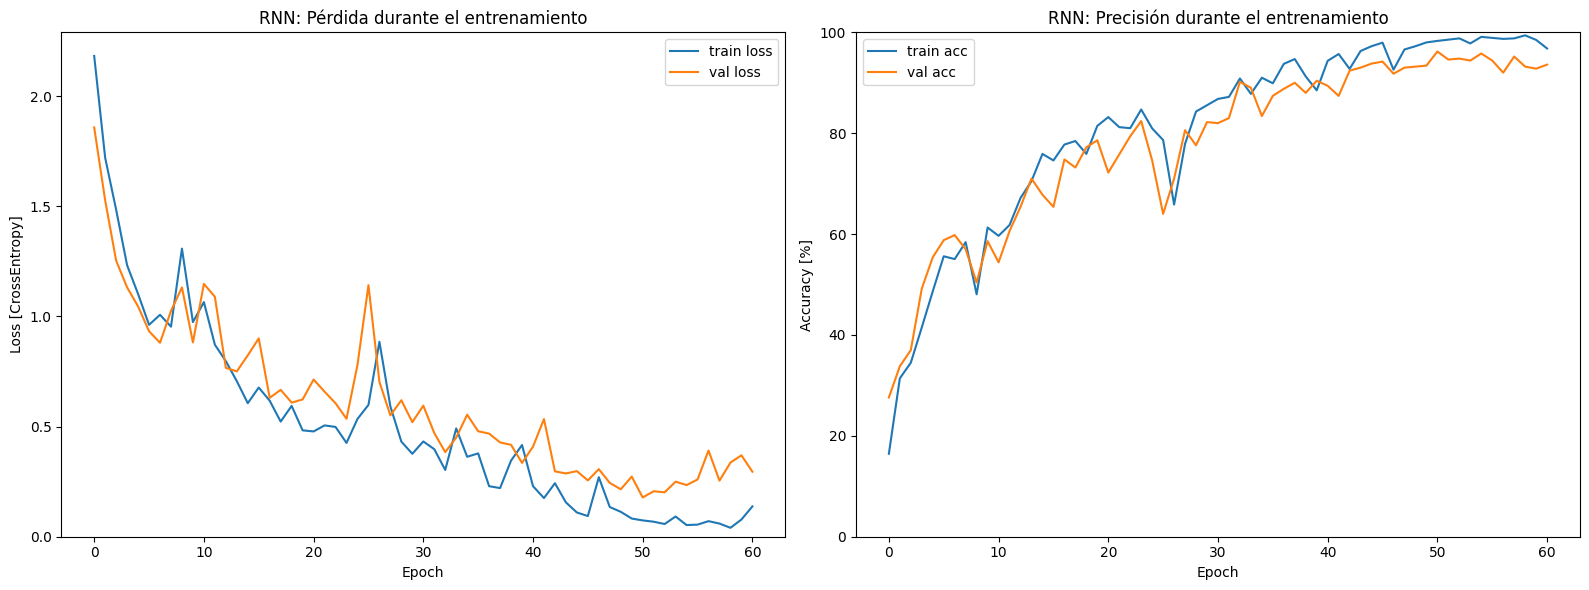

In [150]:
# Extraemos los valores guardados en el history
metrics = history_rnn.history

plt.figure(figsize=(16, 6))

# Pérdida en entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history_rnn.epoch, metrics['loss'],     label='train loss')
plt.plot(history_rnn.epoch, metrics['val_loss'], label='val loss')
plt.legend()
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('RNN: Pérdida durante el entrenamiento')

# Precisión en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history_rnn.epoch, 100 * np.array(metrics['accuracy']),      label='train acc')
plt.plot(history_rnn.epoch, 100 * np.array(metrics['val_accuracy']),  label='val acc')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('RNN: Precisión durante el entrenamiento')

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


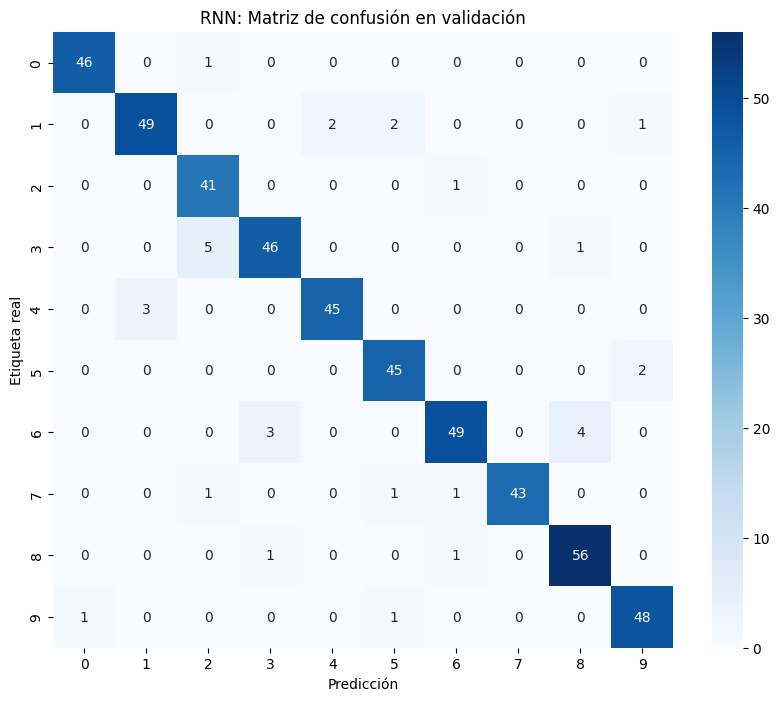

In [151]:
# Obtenemos las predicciones (logits → etiquetas) sobre val_rnn_ds
y_pred_logits_rnn = rnn_model.predict(val_rnn_ds)      # shape: (N_val, 10)
y_pred_rnn = tf.argmax(y_pred_logits_rnn, axis=1)      # shape: (N_val,)

# Extraemos las etiquetas verdaderas concatenando cada batch de val_rnn_ds
y_true_rnn = tf.concat(
    list(val_rnn_ds.map(lambda spec, lbl: lbl)),
    axis=0
).numpy()

# Construir la matriz de confusión
confusion_mtx_rnn = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx_rnn,
    xticklabels=label_names,
    yticklabels=label_names,
    annot=True, fmt='g', cmap='Blues'
)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('RNN: Matriz de confusión en validación')
plt.show()


conclusion rapida (dsp hay que acomodarlo):
cinsigue buenas metricas pero con mas ruido que la cnn -> habria que ver pq se da este caso, para mi que es pq la rnn trabaja con vectores

## Inferimos sobre un audio

In [167]:
# Tomar un clip aleatorio de ds_val (sin batching)
raw_audio, true_label = next(iter(ds_val.shuffle(5000).take(1)))

print("Etiqueta real:", label_names[int(true_label.numpy())],
      "| Forma cruda del audio:", raw_audio.shape)


Etiqueta real: 6 | Forma cruda del audio: (3866,)


In [168]:
audio_8000_rnn, true_label = squeeze_audio(raw_audio, true_label)
print("Después de pad_truncate:", audio_8000_rnn.shape)  # → (8000,)


Después de pad_truncate: (8000,)


In [169]:
spec = get_spectrogram(audio_8000_rnn)
print("Shape del espectrograma:", spec.shape)


Shape del espectrograma: (61, 128, 1)


In [170]:
# Convertir a la forma (1, 61, 128) para pasarlo al RNN
# Primero quitamos el canal: (61,128,1) → (61,128)
spec_rnn = tf.squeeze(spec, axis=-1)
# Luego agregamos batch: (1,61,128)
input_tensor = spec_rnn[tf.newaxis, ...]

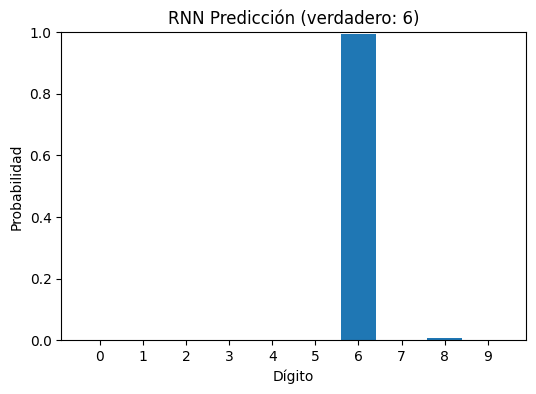

In [171]:
# Predecir con rnn_model
logits = rnn_model(input_tensor)             # shape: (1, 10)
probs  = tf.nn.softmax(logits[0]).numpy()    # vector de 10 probabilidades

# Mostrar gráfico de barras
plt.figure(figsize=(6,4))
plt.bar(label_names, probs)
plt.title(f"RNN Predicción (verdadero: {label_names[int(true_label)]})")
plt.ylabel("Probabilidad")
plt.xlabel("Dígito")
plt.ylim([0, 1])
plt.show()

# eproducir el audio
display.display(display.Audio(audio_8000_rnn.numpy(), rate=8000))
